# Breast Cancer Diagnosis
   
   - Dataset, RDD APIs
   - A dataframe is nothing but a table with columns, rows and headers
   - In this notebook, we will work through a dataset to demostrate spark's SQL-like abilities. We will also look at its machine learning capabilities in context of this dataset.

# 1. Use case
- The chosen dataset is that of Breast Cancer. This set is collected from digitized image of a fine needle aspirate (FNA) of a breast mass. For more information about this dataset, please visit https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
- Each row contains information about a single breast mass along with a diagnosis of malignant/benign for this mass
    
### Problem statement
- We need to learn patterns describing malignant and benign masses and need to be able to place any future samples in either of these buckets.  
- Thus, the problem is a classification one where given a set of probable results, we need to pick one result with confidence. 
    
### Solution
   We will go through the following steps:
   - Read data (Spark SQL)
   - Feature Engineering (Accumulators, Broadcasters, ml/mllib APIs)
   - Data Visualizations (PixieDust, Seaborn)
   - Modeling (Spark ML)
   - Evaluation and prediction (Spark ML)
   - Deployment (Watson ML repository)

In [3]:
from IPython.display import display
from IPython.core.display import HTML 



from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
!pip install seaborn

#### Machine Learning process ###

<center><img width="600px" height="600px" src="https://raw.githubusercontent.com/martinkearn/Content/master/Blogs/Images/MLProcess.PNG"></center>

### Get dataset
!wget https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/data.csv

In [4]:
!wget https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/data.csv

--2017-09-11 12:15:55--  https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125139 (122K) [text/plain]
Saving to: ‘data.csv.13’

100%[======================================>] 125,139     --.-K/s   in 0.008s  

2017-09-11 12:15:55 (15.5 MB/s) - ‘data.csv.13’ saved [125139/125139]



# 2. Data Exploration

In [7]:
# data = spark.read.csv('data.csv',inferSchema='true',header='true')

In [5]:
data = spark.read.format('csv')\
.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
.option('header','true')\
.option('inferSchema','true')\
.load('data.csv')

<center><img width="450px" height="450px" margin="auto" src="https://st2.depositphotos.com/1724125/10885/v/950/depositphotos_108850596-stock-illustration-cartoon-safari-kids.jpg"></center>

### What does our data look like?

In [6]:
data.toPandas()[:10]

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,_c32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,None
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,None
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,None
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,None
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,None
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,None
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,None
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,None
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,None
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,None


### Check datatypes

In [7]:
data.dtypes

[('id', 'int'),
 ('diagnosis', 'string'),
 ('radius_mean', 'double'),
 ('texture_mean', 'double'),
 ('perimeter_mean', 'double'),
 ('area_mean', 'double'),
 ('smoothness_mean', 'double'),
 ('compactness_mean', 'double'),
 ('concavity_mean', 'double'),
 ('concave points_mean', 'double'),
 ('symmetry_mean', 'double'),
 ('fractal_dimension_mean', 'double'),
 ('radius_se', 'double'),
 ('texture_se', 'double'),
 ('perimeter_se', 'double'),
 ('area_se', 'double'),
 ('smoothness_se', 'double'),
 ('compactness_se', 'double'),
 ('concavity_se', 'double'),
 ('concave points_se', 'double'),
 ('symmetry_se', 'double'),
 ('fractal_dimension_se', 'double'),
 ('radius_worst', 'double'),
 ('texture_worst', 'double'),
 ('perimeter_worst', 'double'),
 ('area_worst', 'double'),
 ('smoothness_worst', 'double'),
 ('compactness_worst', 'double'),
 ('concavity_worst', 'double'),
 ('concave points_worst', 'double'),
 ('symmetry_worst', 'double'),
 ('fractal_dimension_worst', 'double'),
 ('_c32', 'string')]

In [8]:
from pyspark.sql.types import FloatType, StringType, IntegerType, DoubleType, ArrayType

for col in data.columns:
    if col not in ['id','diagnosis']:
        data = data.withColumn(col,data[col].cast(FloatType()))

In [9]:
data = data.na.fill(0)

### SQL

#### Register dataframe as a temp table to query from (write sql on dataframes)
    data.registerTempTable('cancer_data')

In [10]:
data.registerTempTable('cancer_data')

#### Querying data
- NOTE that the returned object is another Dataframe
- One nice feature of the notebooks and python is that we can show it in a table via Pandas
- Remember to perform an action to get your results (sql queries are also transformations :))

    query = """
    select
        diagnosis ,
        count(1) as diagnosis_count
    from cancer_data
    group by diagnosis 
    """
    spark.sql(query).toPandas()


In [11]:
query = """
    select
        diagnosis ,
        count(1) as diagnosis_count
    from cancer_data
    group by diagnosis 
    """
spark.sql(query).toPandas()

,diagnosis,diagnosis_count
0,B,357
1,M,212


# 3. Feature Engineering (Data Preparation)
   - Dataset = Features + target
   - Transforming features (categorical to numeric, continous to bins, scaling, normalization etc...)
   - Selecting a subset of columns for wide datasets
   - Exploding columns to make additional (synthetic features) for small datasets
   
   
<img width="450px" height="450px" margin="auto" src="https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAAiuAAAAJGRkNGQzNjU5LTQzOTAtNDRlZC05NTZkLTcxZWM5YmYwZmRkNA.png"></img>

### Step 1: Make sure your target is numeric
- "target" is categorical (malignant/benign)
- Our encoding: 1 = malignant(M), 0 = Benign(B) using sql like "when" statement

In [12]:
# #### Replace null values with 0
# data = data.na.fill(0)

### Step 2: Sample your data to view what it looks like before we make changes to the target column

    data.select('diagnosis','radius_se').show(3)

In [13]:
data.select('diagnosis','radius_se').show(3)

+---------+---------+
|diagnosis|radius_se|
+---------+---------+
|        M|    1.095|
|        M|   0.5435|
|        M|   0.7456|
+---------+---------+
only showing top 3 rows



#### Make label numeric

In [14]:
import  pyspark.sql.functions as F

data = data.withColumn('diagnosis',F.when(data.diagnosis=='M',1).otherwise(0))
data.toPandas().head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,_c32
0,842302,1,17.990000,10.38,122.800003,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.330000,184.600006,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,842517,1,20.570000,17.77,132.899994,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.410000,158.800003,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,84300903,1,19.690001,21.25,130.000000,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.530001,152.500000,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0


#### Rename column from "diagnosis" to "label"

In [15]:
data = data.withColumnRenamed('diagnosis','label')
data.toPandas().head(3)

,id,label,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,_c32
0,842302,1,17.990000,10.38,122.800003,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.330000,184.600006,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,842517,1,20.570000,17.77,132.899994,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.410000,158.800003,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,84300903,1,19.690001,21.25,130.000000,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.530001,152.500000,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0


In [16]:
def count_labels(row):
    global benign, malignant
    if row.label==1:
        malignant.add(1)
    else:
        benign.add(1)

#### Collect statistics for your dataset ###
- Collect statistics for mean/std
- store it in a variable called "df"

In [17]:
df = data.describe()
df.toPandas()

,summary,id,label,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,_c32
0,count,569,569,569,569,569,569,569,569,569,...,569,569,569,569,569,569,569,569,569,569
1,mean,3.0371831432337433E7,0.37258347978910367,14.127291743072348,19.289648528677297,91.96903329993384,654.889103814043,0.09636028129312821,0.10434098429781481,0.08879931578830029,...,25.67722316534113,107.26121279644421,880.5831290514901,0.13236859435565862,0.25426504394016597,0.2721884833807977,0.11460622294146325,0.2900755708948799,0.08394581713895387,0.0
2,stddev,1.2502058561222367E8,0.4839179564031687,3.524048812967195,4.301035792275387,24.298980946187076,351.91412886139733,0.014064128011679866,0.05281275807458227,0.07971980885275734,...,6.146257611231105,33.602542264508905,569.3569923849643,0.022832429559187094,0.15733648854662943,0.20862428007810724,0.06573234105890066,0.06186746818484165,0.01806126727675421,0.0
3,min,8670,0,6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,...,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504,0.0
4,max,911320502,1,28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,...,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075,0.0


#### Calculate correlations of each columns w.r.t the target
- Change to do this in spark



#### Select a subset of columns
- Remove columns conveying very little information
   - Zero variance columns
   - Low correlation columns

In [18]:
df = data.toPandas()
col_corr = sorted(df.corr()['label'].to_dict().items(),key=lambda x:x[1],reverse=True)
for col in col_corr[-5:]:
    if col[0]!='id':
        data = data.drop(col[0])

- Remove columns with low correlation, such columns contribute to very little information
- Caution: Be wary of multicolinearity ("leaky" columns)

## Vizualise Data (Lets do some graphs!)

###  Here, we look at the columns and their correlations with the target variable.
- We use PixieDust (charting library) for quick charts
- Also takes RDDs as inputs, most of the other charting librabries take pandas dataframes as inputs

In [19]:
# !pip install --user --upgrade pixiedust

In [21]:
import pixiedust
import pandas as pd

df = pd.DataFrame(col_corr)
df = df.dropna()
df.columns = ['name','correlation']
viz_spark_df = sqlContext.createDataFrame(df)


display(viz_spark_df)

### Visualize correlations ####
 - Useful for datasets with small number of columns
 - A heatmap is useful to visualize how variables are related to each other (and not just the target)
 - Very useful while doing NLP applications to visualize similarity between documents (after using TFIDF)
 

/gpfs/fs01/user/s280-a46e86a84e2274-95b1885704d4/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


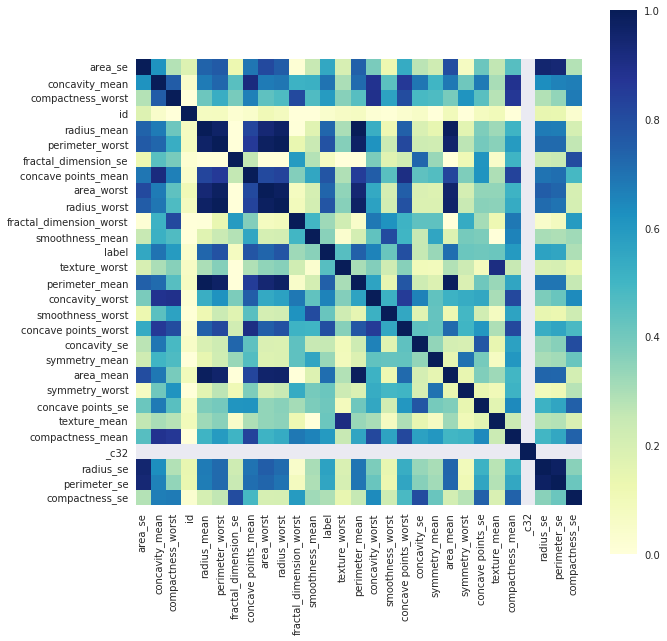

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.mllib.stat import Statistics

plt.style.use('ggplot')
values = data.rdd.map(lambda x:list(x.asDict().values()))
corr_values = Statistics.corr(values)
names = data.rdd.map(lambda x:list(x.asDict().keys())).first()

plt.figure(figsize=(10,10))
sns.set_style("darkgrid")
sns.heatmap(corr_values,xticklabels=names,yticklabels=names,square=True,vmin=0, vmax=1,
                cmap="YlGnBu")

In [30]:
feature_cols
data = data.drop('_c32')

In [31]:
###### PCA Visualize data ######
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import VectorAssembler 

feature_cols = list(filter(lambda x:x not in ['id','label','dummy'],data.columns))
assembler = VectorAssembler(inputCols=feature_cols,outputCol='features')
df = assembler.transform(data)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

pca_result = model.transform(df)
result = pca_result.select("pcaFeatures")


# 4. We are all set to do some machine learning!


<center><img width="350px" height="350px" margin="auto" src="http://www.clipartkid.com/images/127/cartoon-explorer-characters-vectors-6cbSmI-clipart.jpg"></center>

## Visualize problem
### PCA  - Dimensionality Reduction 

In [32]:
%matplotlib inline

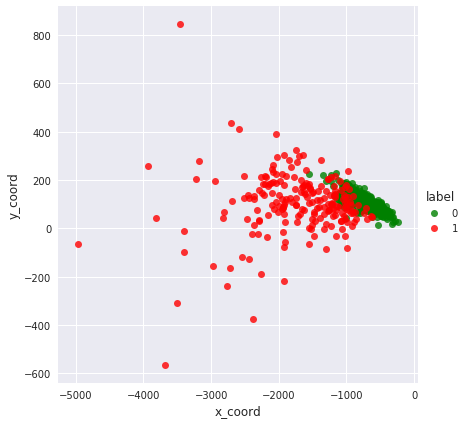

In [33]:
import regex

def g(point,co_ord):
    if co_ord=='x':
        value = regex.split('\s+',point)[0][1:]
    else:
        value =  regex.split('\s+',point)[1][:-1]
    return value

get_x_coord = UserDefinedFunction(lambda point:g(point,'x'), StringType())
get_y_coord = UserDefinedFunction(lambda point:g(point,'y'), StringType())
convert_to_string = UserDefinedFunction(lambda point:str(point.toArray()),StringType())

pca_result = pca_result.withColumn('pcaFeatures_string',convert_to_string(pca_result['pcaFeatures']))
pca_result = pca_result.withColumn('x_coord',get_x_coord(pca_result['pcaFeatures_string']))\
                       .withColumn('y_coord',get_y_coord(pca_result['pcaFeatures_string']))\
                      
pca_result = pca_result.withColumn('x_coord',pca_result.x_coord.cast(FloatType()))\
                       .withColumn('y_coord',pca_result.y_coord.cast(FloatType()))
    
viz_df = pca_result.select('x_coord','y_coord','label').toPandas()


a = sns.lmplot(x='x_coord',y='y_coord',hue='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)

In [34]:
#### Convert 'label' to DoubleType()
data = data.withColumn('label',data['label'].cast(DoubleType()))

In [35]:
#### Split dataset into test and train sets (70/30) splits
train, test = data.randomSplit([0.7,0.3])

In [36]:
#### Count number of records in test and train sets
train.count(), test.count()

(390, 179)

In [37]:
from pyspark.ml.pipeline import Pipeline

In [38]:
#### Define Assembler to combine feature into a single vetor (feature vector! :) )
from pyspark.ml.linalg import Vectors #linear algebra package, has matrices, arrays, Vectors (dense and sparse)
from pyspark.ml.feature import VectorAssembler 

feature_cols = list(filter(lambda x:x not in ['id','label'],data.columns))
assembler = VectorAssembler(inputCols=feature_cols,outputCol='features')

### Classification Pipelines 
- Tree based classifier
- Logistic Regression

<center><img src="https://codesachin.files.wordpress.com/2015/08/linearly_separable_4.png"></center>

### Results from a decision tree classifier

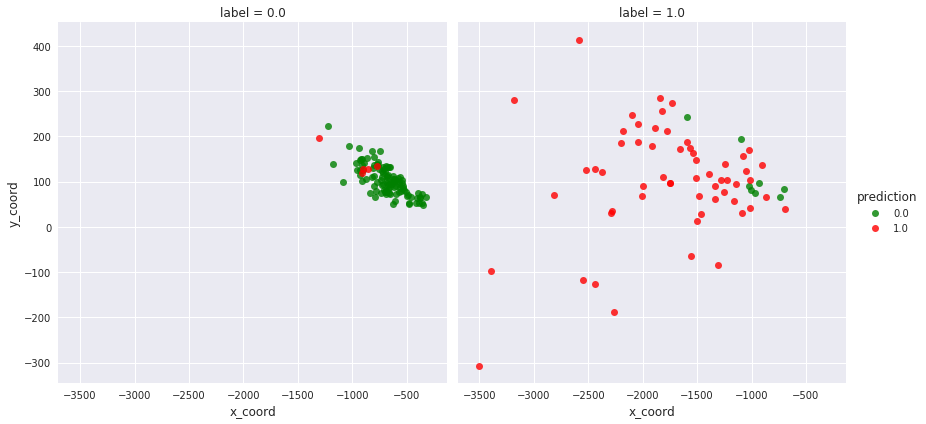

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
# define estimator and fit data
estimator = DecisionTreeClassifier()
pipeline = Pipeline(stages=[assembler,estimator])
tree_model = pipeline.fit(train)

# get results
results = tree_model.transform(test)
dt_classider = results

### Visualize the results of tree classifier ###
pca_subset = pca_result.select('ID','features','x_coord','y_coord')
viz_df = pca_subset.join(results,on=['ID','features']).select('x_coord','y_coord','prediction','label')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)

In [37]:
#### Classification metrics ####
def calc_metrics(results):
    metrics = {}
    metrics['tp_0'] = results.filter((results.label==0)&(results.prediction==0)).count()
    metrics['fn_0'] = results.filter((results.label==0)&(results.prediction==1)).count()
    metrics['tn_0'] = results.filter((results.label==1)&(results.prediction==1)).count()
    metrics['fp_0'] = results.filter((results.label==1)&(results.prediction==0)).count()
    
    metrics['tp_1'] = results.filter((results.label==1)&(results.prediction==1)).count()
    metrics['fn_1'] = results.filter((results.label==1)&(results.prediction==0)).count()
    metrics['tn_1'] = results.filter((results.label==0)&(results.prediction==0)).count()
    metrics['fp_1'] = results.filter((results.label==0)&(results.prediction==1)).count()
    
    return metrics
        
### calc precision & recall ###
def precision_recall(results):
    items = calc_metrics(results)
    rows = []
    
    row = {'class':0,'precision':items['tp_0']/float((items['tp_0']+items['fp_0'])+1),'recall':items['tp_0']/float((items['tp_0']+items['fn_0'])+1)}
    rows.append(row)
    row = {'class':1,'precision':items['tp_1']/float((items['tp_1']+items['fp_1'])+1),'recall':items['tp_1']/float((items['tp_1']+items['fn_1'])+1)}
    rows.append(row)
    
    return rows

In [32]:
from pyspark.ml.classification import LogisticRegression

#define estimator and fit data
estimator = LogisticRegression()
pipeline = Pipeline(stages=[assembler,estimator])
lr_model = pipeline.fit(train)

#get results
results = lr_model.transform(test)

In [33]:
lr_results = results

### Results from Logistic regression classifier

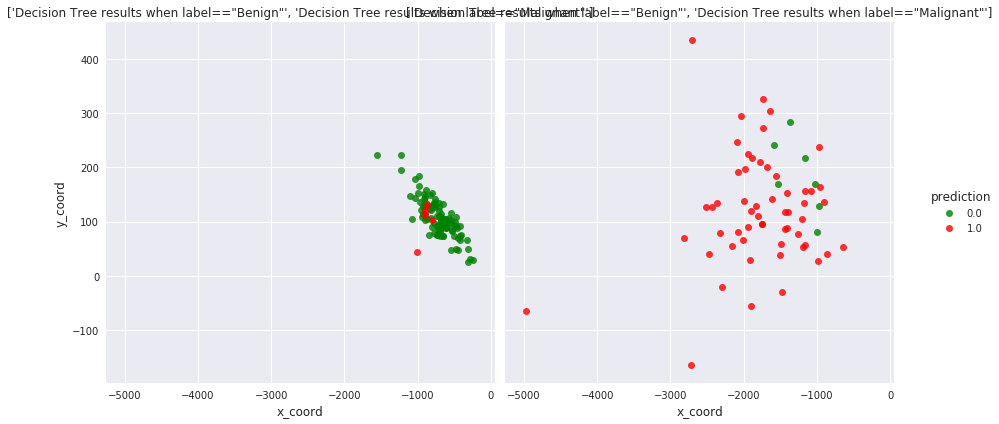

In [34]:
### Visualize results from logistic regression ###
pca_subset = pca_result.select('id','features','x_coord','y_coord')
viz_df = pca_subset.join(results,on=['id','features']).select('x_coord','y_coord','prediction','label')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)
a.set_titles(col_template=['Decision Tree results when label=="Benign"','Decision Tree results when label=="Malignant"'])

### Evaluation

- Classification models work towards making a Yes/No decision
- Metrics to evaluate the model: Precision/Recall, AUC


<center><img width="500px" height="500px" src="http://opexanalytics.com/cnt/uploads/2016/01/Red-Fish-High-Recall.jpg"></center>

In [41]:
### Precision Recall scores from Decision Tree Classifier
import pandas as pd
pd.DataFrame(precision_recall(dt_classider))

,class,precision,recall
0,0,0.915888,0.915888
1,1,0.859375,0.859375


### Precision Recall scores from Logistic Regression Classifier

In [42]:
pd.DataFrame(precision_recall(lr_results))

,class,precision,recall
0,0,0.926606,0.943925
1,1,0.903226,0.875000


## How would an approach other than classification perform?

### K-means clustering

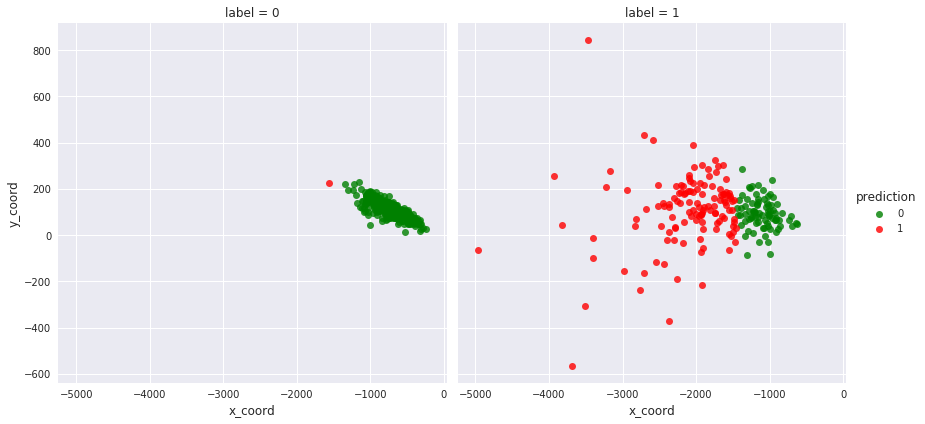

In [49]:
######## Kmeans clustering, join to the PCA set #########
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2,featuresCol='features')
model = kmeans.fit(pca_result)
centers = model.clusterCenters()
kmeans_result = model.transform(pca_result).select('id','features','prediction')

viz_df = pca_result.join(kmeans_result,on=['id','features'],how='inner')\
                   .select('id','features','x_coord','y_coord','prediction','label')

viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)

# 5. Deploy to Cloud by using Watson Machine Learning Repo

- Deploy your model with a few lines of code
- Provides a link that can be embedded into applications (easy hand-off from data scientists to developers)

IBM WML Reference: http://watson-ml-api.mybluemix.net/#/Online32Scoring


### Step 1: Setup credentials ###

In [ ]:
# The code was removed by DSX for sharing.

### Step 2: Save model ### 

In [80]:
### Required imports ###
import urllib3, requests, json

### Authenticate ML repo ###
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

### Save model ###
model_artifact_lr = MLRepositoryArtifact(lr_model, training_data=train, name="Logistic Regression Classifer")
saved_model = ml_repository_client.models.save(model_artifact_lr)

### Load saved model and make predictions (batch) ###

In [81]:
#### load model ###
loadedModelArtifact = ml_repository_client.models.get(saved_model.uid)

### make predictions ####
predictions = loadedModelArtifact.model_instance().transform(test)
precision_recall(predictions)

{'pre_0': 0.9907407407407407,
 'pre_1': 1.0,
 'recall_0': 1.0,
 'recall_1': 0.9836065573770492}

### Obtain token to interact with REST API ###

In [55]:
### get token ###
headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
url = '{}/v2/identity/token'.format(service_path)
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

### Deploy model ###

In [53]:
### deploy model ###
endpoint_online = service_path + "/v2/online/deployments/"
header_online = {'Content-Type': 'application/json', 'Authorization': mltoken}
payload_online = {"artifactVersionHref": saved_model.meta.prop("modelVersionHref"), "name": "Product Line Prediction"}

response_online = requests.post(endpoint_online, json=payload_online, headers=header_online)
scoring_href = json.loads(response_online.text).get('entity').get('scoringHref') ## this is the endpoint used for online scoring

### Get list of existing models, obtain scoring endpoint for the desired model ###

In [114]:
### get a list of existing deployments ###
url = service_path + "/v2/online/deployments"
header_online = {'Content-Type': 'application/json', 'Authorization': mltoken}

# get scoring endpoint for this model
resp = requests.get(url,headers=header_online)
scoring_href = resp.json()['resources'][0]['entity']['scoringHref']

### Get predictions from model (online predictions) ###

In [115]:
### example of getting prediction with online scoring ####
test_row = test.take(5)[3]
test_features = [test_row[col] for col in test.columns if col not in ['label']]

# get prediction from online scoring endpoint (scoring_href from above)
payload_scoring = {"record":test_features}
response_scoring = requests.put(scoring_href, json=payload_scoring, headers=header_online)


In [118]:
from IPython.display import display

output = response_scoring.json()
print ('Output from scoring endpoint')
display(output)

Output from scoring endpoint


{u'result': {u'AREA_MEAN': 1264.0,
  u'AREA_SE': 87.87000274658203,
  u'AREA_WORST': 1750.0,
  u'COMPACTNESS_MEAN': 0.13130000233650208,
  u'COMPACTNESS_SE': 0.03482000157237053,
  u'COMPACTNESS_WORST': 0.3538999855518341,
  u'CONCAVE POINTS_MEAN': 0.08682999759912491,
  u'CONCAVE POINTS_SE': 0.012690000236034393,
  u'CONCAVE POINTS_WORST': 0.15729999542236328,
  u'CONCAVITY_MEAN': 0.14650000631809235,
  u'CONCAVITY_SE': 0.042319998145103455,
  u'CONCAVITY_WORST': 0.4097999930381775,
  u'FRACTAL_DIMENSION_SE': 0.0044109998270869255,
  u'FRACTAL_DIMENSION_WORST': 0.08367999643087387,
  u'ID': 86208,
  u'PERIMETER_MEAN': 132.39999389648438,
  u'PERIMETER_SE': 4.553999900817871,
  u'PERIMETER_WORST': 156.10000610351562,
  u'RADIUS_MEAN': 20.260000228881836,
  u'RADIUS_SE': 0.7576000094413757,
  u'RADIUS_WORST': 24.219999313354492,
  u'SMOOTHNESS_MEAN': 0.09077999740839005,
  u'SMOOTHNESS_WORST': 0.11900000274181366,
  u'SYMMETRY_MEAN': 0.2094999998807907,
  u'SYMMETRY_WORST': 0.3689000010

In [121]:
print 'Prediction:',output['result']['prediction']
print 'Probability:',output['result']['probability']['values']
print 'RawPrediction:',output['result']['probability']['values']

Prediction: 1.0
Probability: [1.413173287357375e-34, 1.0]
RawPrediction: [1.413173287357375e-34, 1.0]
